# WeatherPy

---

## Starter Code to Generate Random Geographic Coordinates and a List of Cities

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

# Impor the OpenWeatherMap API key
from api_keys import weather_api_key
#print(weather_api_key)

# Import citipy2 to determine the cities based on latitude and longitude ### SEE NOTE FOR NEW MODULE
import citipy2

### Generate the Cities List by Using the `citipy2` Library

In [4]:
# Empty list for holding the latitude and longitude combinations
lat_lngs = []

# Empty list for holding the cities names
cities = []

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
# AND push the actual lat, lng for those cities into new lists
true_lats = []
true_lngs = []
for lat_lng in lat_lngs:
    city = citipy2.nearest_city(lat_lng[0], lat_lng[1])
    mycityname = city.city_name
    
    # If the city is unique, then add it to a our cities list
    # note: I see that this given code is only taking unique city names.
    if mycityname not in cities:
        cities.append(mycityname)
        city_lat = city.city_lat
        true_lats.append(city_lat)
        city_lng = city.city_long
        true_lngs.append(city_lng)

# Print the city count to confirm sufficient count
print(f"Number of cities in the list: {len(cities)}")
#shortcities = cities[0:100]
#print(shortcities)

Number of cities in the list: 635


In [8]:
# sanity checks
print(cities[0], true_lats[0], true_lngs[0])
print(citipy2.get_coordinates('jamestown'))

print(cities[24], true_lats[24], true_lngs[24])
print(citipy2.get_coordinates('hithadhoo'))

jamestown -15.9333333 -5.7166667
('-15.9333333', '-5.7166667')
hithadhoo -0.6 73.0833333
('-0.6', '73.0833333')


---

## Requirement 1: Create Plots to Showcase the Relationship Between Weather Variables and Latitude

### Use the OpenWeatherMap API to retrieve weather data from the cities list generated in the started code

In [ ]:
# Something seemed wrong with the provided code. It is possible that I just mangled it but I was having a hard time with the citypy module.
# The first issue is that the random coordinates were assigned a city, but not corrected to the true coordinates of that city.
# Thus, when I mapped it, the city name appeared next to a dot that was often in the middle of nowhere (like the ocean).
# Also, when I searched for hotels in the next section of the homework, many cities had no hotels because of their distance from anywhere.
# There is a second issue in VSCode where it sometimes (but not always) says that citipy does not have a nearest_city attribute. Sometimes code just stops working.

# I attempted to update the code here to the following logic instead:
# - Get random coordinates
# - Find the nearest city to those coordinates
# - Get the real coordinates for that city
# - Then call the API with real coordinates to get actual weather data for the city, rather than the random coordinates that we selected randomly

# Note: this is also what appears to be necessary to get a result looking like the example map, which has no marks in the ocean, which wouldn't happen with true random coordinates

# Additionally, the citipy module does not have the ability to feed in a city and return coordinates and typing it up on it's own was a pain.
# I thought about contributing that to the citipy module but don't want to break things.
# Instead, I copied the module to a new module and edited that. The new module is citipy2. This puts required features in that module and keeps this notebook cleaner.
# This new module is in the same directory as this notebook, and uses the same csv for data, which I also copied over.
# I am adding this citipy2 module to github so it can be reviewed as part of this work.

# Features added in citipy2:
# 1) city object has latitude and longitude. I use this below.
# 2) created function that takes a city input as a string and returns coordinates (works for the first city in the list, beware duplicates). Used in testing.

In [3]:
# Set the API base URL
url = "https://api.openweathermap.org/data/3.0/onecall?lat={lat}&lon={lon}&exclude={part}&appid={API_key}"

# Define an empty list to fetch the weather data for each city
city_data = []

# Print to logger
print("Beginning Data Retrieval     ")
print("-----------------------------")

# Create counters
record_count = 1
set_count = 1

# Loop through all the cities in our list to fetch weather data
for i, city in enumerate(cities):
        
    # Group cities in sets of 50 for logging purposes
    if (i % 50 == 0 and i >= 50):
        set_count += 1
        record_count = 0

    # Create endpoint URL with each city
    #print(lats[i], lngs[i])
    mylats = true_lats[i]
    mylngs = true_lngs[i]
    # Below is a version that uses the new citipy2 attribute: feeding a city name and getting the real coordinates back.
    # Now when we make the API call we will be calling for the correct coordinates for the city we want.
    #mycoords = citipy2.get_coordinates(city)
    #mylats = mycoords[0]
    #mylngs = mycoords[1]
    city_url = url.format(lat = mylats, lon = mylngs, part = "hourly, daily", API_key = weather_api_key)
    #print(city_url)
    
    # Log the url, record, and set numbers
    print("Processing Record %s of Set %s | %s" % (record_count, set_count, city))

    # Add 1 to the record count
    record_count += 1

    # Run a API request for each of the cities
    try:
        response = requests.get(city_url)
        #print(response)
        data = response.json()
        #print(data)
        city_weather = data["current"]["weather"][0]["main"] # The [0] here is because it seems like weather was a string? I call the first index of the string then can access the rest as a dict
        #print(city_weather)
        # Parse out latitude, longitude, max temp, humidity, cloudiness, wind speed, country, and date
        city_lat = data["lat"]
        #print(city_lat)
        city_lng = data["lon"]
        #print(city_lng)
        city_max_temp = data["daily"][0]["temp"]["max"] #again using the [0] trick. That was a weird one to figure out.
        city_max_temp = (city_max_temp - 273.15) * 1.8 + 32 # Converting from Kelvin to Farenheit because I got way through this exercise before realizing I should have used imperial. This is easy.
        #print(city_max_temp)
        city_humidity = data["daily"][0]["humidity"]
        #print(city_humidity)
        city_clouds = data["daily"][0]["clouds"]
        #print(city_clouds)
        city_wind = data["daily"][0]["wind_speed"]
        #print(city_wind)
        city_country = citipy.nearest_city(city_lat, city_lng).country_code # I had to use a city object in order to pull country, but i only had a list of cities as strings, so i re-create it here. Seems inefficient but I couldn't solve it otherwise.
        #print(city_country)
        city_date = data["current"]["dt"]
        #print(city_date)
        # Append the City information into city_data list
        city_data.append({"City": city, 
                          "Lat": city_lat, 
                          "Lng": city_lng, 
                          "Max Temp": city_max_temp,
                          "Humidity": city_humidity,
                          "Cloudiness": city_clouds,
                          "Wind Speed": city_wind,
                          "Country": city_country,
                          "Date": city_date})
    # If an error is experienced, skip the city
    except:
        print("City not found. Skipping...")
        pass


# Indicate that Data Loading is complete 
print("-----------------------------")
print("Data Retrieval Complete      ")
print("-----------------------------")

# print(city_data)

Beginning Data Retrieval     
-----------------------------
Processing Record 1 of Set 1 | mataura
Processing Record 2 of Set 1 | cape town
Processing Record 3 of Set 1 | castro
Processing Record 4 of Set 1 | lebu
Processing Record 5 of Set 1 | provideniya
Processing Record 6 of Set 1 | lavrentiya
Processing Record 7 of Set 1 | hilo
Processing Record 8 of Set 1 | vaitupu
Processing Record 9 of Set 1 | sebinkarahisar
Processing Record 10 of Set 1 | busselton
Processing Record 11 of Set 1 | cayenne
Processing Record 12 of Set 1 | barrow
Processing Record 13 of Set 1 | kloulklubed
Processing Record 14 of Set 1 | tasiilaq
Processing Record 15 of Set 1 | pangnirtung
Processing Record 16 of Set 1 | benguela
Processing Record 17 of Set 1 | kapaa
Processing Record 18 of Set 1 | barentsburg
Processing Record 19 of Set 1 | saskylakh
Processing Record 20 of Set 1 | paramonga
Processing Record 21 of Set 1 | mount isa
Processing Record 22 of Set 1 | fiumicino
Processing Record 23 of Set 1 | comarap

In [4]:
# Convert the cities weather data into a Pandas DataFrame
city_data_df = pd.DataFrame.from_dict(city_data)

# Show Record Count
city_data_df.count()

City          651
Lat           651
Lng           651
Max Temp      651
Humidity      651
Cloudiness    651
Wind Speed    651
Country       651
Date          651
dtype: int64

In [5]:
# Display sample data
city_data_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,mataura,-30.2696,-142.2187,71.564,73,100,4.85,pf,1681238065
1,cape town,-74.0574,-13.8915,22.658,84,100,14.68,za,1681238065
2,castro,-50.4194,-93.1736,46.292,81,98,12.22,cl,1681238066
3,lebu,-29.8731,-98.4434,67.964,65,100,4.13,cl,1681238067
4,provideniya,54.7988,-173.9100,38.246,78,48,12.02,ru,1681238068


In [6]:
# Export the City_Data into a csv
city_data_df.to_csv("../output_data/cities.csv", index_label="City_ID")

In [7]:
# Read saved data
city_data_df = pd.read_csv("../output_data/cities.csv", index_col="City_ID")

# Display sample data
city_data_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
City_ID,,,,,,,,,
0,mataura,-30.2696,-142.2187,71.564,73,100,4.85,pf,1681238065
1,cape town,-74.0574,-13.8915,22.658,84,100,14.68,za,1681238065
2,castro,-50.4194,-93.1736,46.292,81,98,12.22,cl,1681238066
3,lebu,-29.8731,-98.4434,67.964,65,100,4.13,cl,1681238067
4,provideniya,54.7988,-173.9100,38.246,78,48,12.02,ru,1681238068


### Create the Scatter Plots Requested

#### Latitude Vs. Temperature

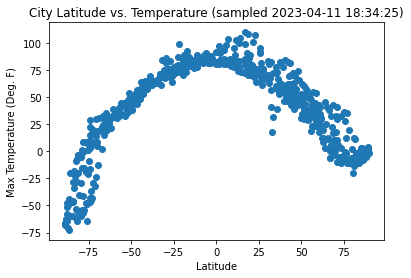

In [8]:
# Build scatter plot for latitude vs. temperature
plt.scatter(city_data_df["Lat"], city_data_df["Max Temp"], marker = "o")

# Incorporate the other graph properties
date_of_sample = pd.to_datetime(city_data_df["Date"], unit = "s")
min_date = date_of_sample.min()
plt.title(f"City Latitude vs. Temperature (sampled {min_date})")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (Deg. F)")

# Save the figure
plt.savefig("../output_data/Fig1.png")

# Show plot
plt.show()

#### Latitude Vs. Humidity

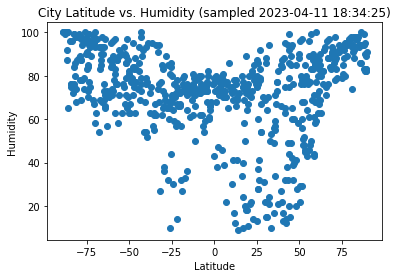

In [9]:
# Build the scatter plots for latitude vs. humidity
plt.scatter(city_data_df["Lat"], city_data_df["Humidity"], marker = "o")

# Incorporate the other graph properties

plt.title(f"City Latitude vs. Humidity (sampled {min_date})")
plt.xlabel("Latitude")
plt.ylabel("Humidity")

# Save the figure
plt.savefig("../output_data/Fig2.png")

# Show plot
plt.show()

#### Latitude Vs. Cloudiness

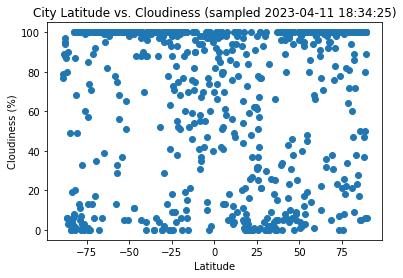

In [10]:
# Build the scatter plots for latitude vs. cloudiness
plt.scatter(city_data_df["Lat"], city_data_df["Cloudiness"], marker = "o")

# Incorporate the other graph properties

plt.title(f"City Latitude vs. Cloudiness (sampled {min_date})")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")

# Save the figure
plt.savefig("../output_data/Fig3.png")

# Show plot
plt.show()

#### Latitude vs. Wind Speed Plot

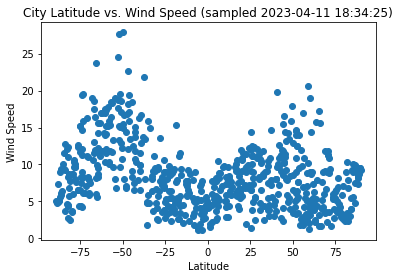

In [12]:
# Build the scatter plots for latitude vs. wind speed
plt.scatter(city_data_df["Lat"], city_data_df["Wind Speed"], marker = "o")

# Incorporate the other graph properties

plt.title(f"City Latitude vs. Wind Speed (sampled {min_date})")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed")
# Save the figure
plt.savefig("../output_data/Fig4.png")

# Show plot
plt.show()

---

## Requirement 2: Compute Linear Regression for Each Relationship


r-value =  -0.28356155013153284


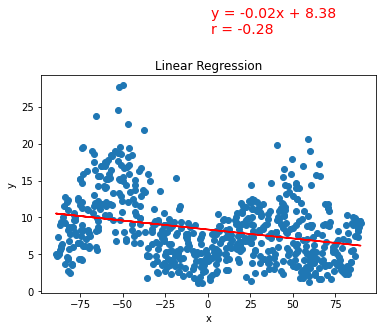

In [13]:
# Define a function to create Linear Regression plots

import math # this is a standard library and I need it for the square root functions

def linear_regression(x, y):
    n = len(x)
    x_mean = sum(x) / n
    y_mean = sum(y) / n
    # calculate R value
    x_stddev = math.sqrt(sum([(i - x_mean)**2 for i in x]) / (len(x) - 1))
    y_stddev = math.sqrt(sum([(i - y_mean)**2 for i in y]) / (len(y) - 1))
    covariance = sum([(x[i] - x_mean) * (y[i] - y_mean) for i in range(len(x))]) / (len(x) - 1)
    r_value = covariance / (x_stddev * y_stddev)
    print("r-value = ", r_value)
    # calculate slope and intercept for plotting
    slope = sum([(x[i] - x_mean) * (y[i] - y_mean) for i in range(n)]) / sum([(x[i] - x_mean) ** 2 for i in range(n)])
    intercept = y_mean - slope * x_mean
    # do the plotting
    plt.scatter(x, y)
    plt.plot(x, [slope * xi + intercept for xi in x], color='red')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Linear Regression')
    # add the equation to the plot
    plt.text(x.mean(),y.max()*1.25,f"y = {slope:.2f}x + {intercept:.2f}\nr = {r_value:.2f}", color='red', size = '14')
    plt.show()


linear_regression(city_data_df["Lat"], city_data_df["Wind Speed"])

r-value = -0.283561550131533


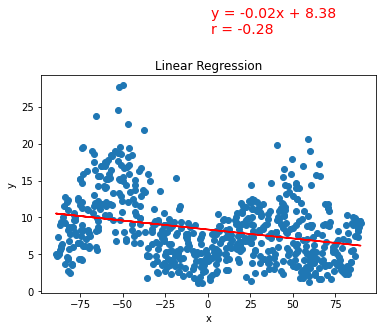

In [17]:
# # Define a function to create Linear Regression plots

def linear_regression(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    print("r-value =", r_value)
    plt.scatter(x, y)
    plt.plot(x, slope*x + intercept, color='red')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Linear Regression')
    plt.text(x.mean(), y.max()*1.25, f"y = {slope:.2f}x + {intercept:.2f}\nr = {r_value:.2f}", color='red', size='14')
    plt.show()

linear_regression(city_data_df["Lat"], city_data_df["Wind Speed"])

In [18]:
# Create a DataFrame with the Northern Hemisphere data (Latitude >= 0)
northern_hemi_df = city_data_df[city_data_df["Lat"]>=0]
northern_hemi_df = northern_hemi_df.reset_index(drop=True)


# Display sample data
northern_hemi_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,provideniya,54.7988,-173.9100,38.246,78,48,12.02,ru,1681238068
1,lavrentiya,77.4458,-169.7338,-6.916,95,82,4.70,ru,1681238069
2,hilo,5.0055,-157.5343,80.708,81,80,7.82,us,1681238069
3,vaitupu,5.0766,-174.5124,82.544,78,52,8.17,wf,1681238070
4,sebinkarahisar,39.9500,38.6616,46.040,87,100,3.67,tr,1681238071


In [19]:
# Create a DataFrame with the Southern Hemisphere data (Latitude < 0)
southern_hemi_df = city_data_df[city_data_df["Lat"]<=0]
southern_hemi_df = southern_hemi_df.reset_index(drop=True)


# Display sample data
southern_hemi_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,mataura,-30.2696,-142.2187,71.564,73,100,4.85,pf,1681238065
1,cape town,-74.0574,-13.8915,22.658,84,100,14.68,za,1681238065
2,castro,-50.4194,-93.1736,46.292,81,98,12.22,cl,1681238066
3,lebu,-29.8731,-98.4434,67.964,65,100,4.13,cl,1681238067
4,busselton,-87.9741,77.0392,-63.922,100,94,5.07,au,1681238072


###  Temperature vs. Latitude Linear Regression Plot

r-value = -0.9223352655414239


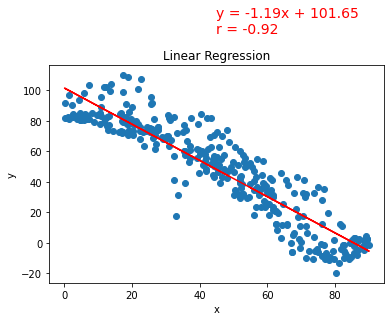

In [20]:
# Linear regression on Northern Hemisphere
linear_regression(northern_hemi_df["Lat"], northern_hemi_df["Max Temp"])

r-value = 0.912994906136718


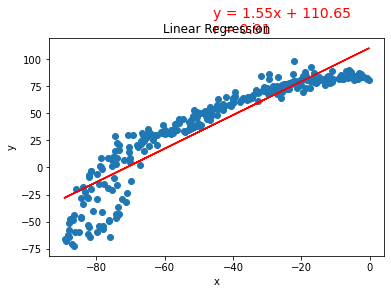

In [21]:
# Linear regression on Southern Hemisphere
linear_regression(southern_hemi_df["Lat"], southern_hemi_df["Max Temp"])

**Discussion about the linear relationship:** YOUR RESPONSE HERE

### Humidity vs. Latitude Linear Regression Plot

r-value = 0.44114294929687753


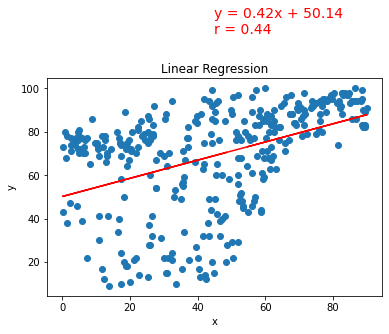

In [22]:
# Northern Hemisphere

linear_regression(northern_hemi_df["Lat"], northern_hemi_df["Humidity"])

r-value = -0.4971783647793798


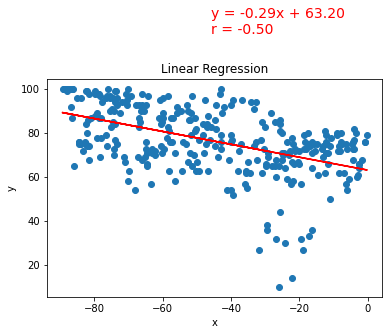

In [23]:
# Southern Hemisphere

linear_regression(southern_hemi_df["Lat"], southern_hemi_df["Humidity"])

**Discussion about the linear relationship:** YOUR RESPONSE HERE

### Cloudiness vs. Latitude Linear Regression Plot

r-value = 0.17338039373117412


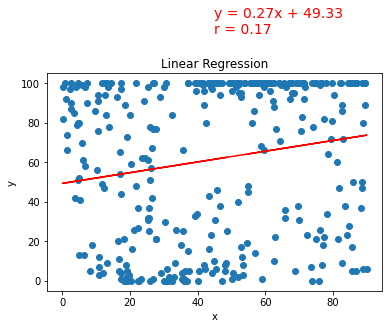

In [24]:
# Northern Hemisphere

linear_regression(northern_hemi_df["Lat"], northern_hemi_df["Cloudiness"])

r-value = -0.4971783647793798


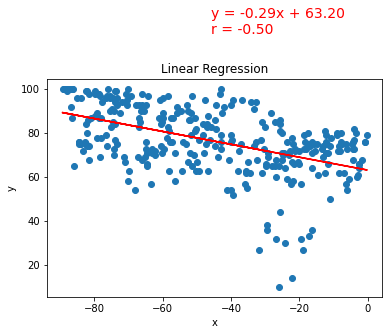

In [25]:
# Southern Hemisphere

linear_regression(southern_hemi_df["Lat"], southern_hemi_df["Humidity"])

**Discussion about the linear relationship:** YOUR RESPONSE HERE

### Wind Speed vs. Latitude Linear Regression Plot

r-value = -0.021419836798695198


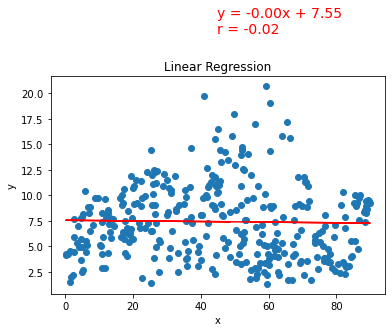

In [26]:
# Northern Hemisphere

linear_regression(northern_hemi_df["Lat"],northern_hemi_df["Wind Speed"])

r-value = -0.3302956807691281


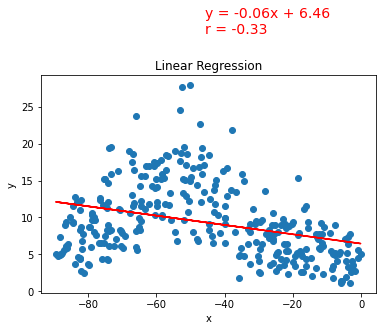

In [27]:
# Southern Hemisphere

linear_regression(southern_hemi_df["Lat"], southern_hemi_df["Wind Speed"])

**Discussion about the linear relationship:** YOUR RESPONSE HERE